# Reinforcement Learning: Q-Learning and SARSA Algorithms

## Overview

This module implements two fundamental **temporal difference (TD) learning** algorithms for reinforcement learning:

- **Q-Learning**: Off-policy algorithm that learns the optimal policy while following an exploratory policy
- **SARSA**: On-policy algorithm that learns the policy being followed

Both algorithms learn action-value functions Q(s,a) representing the expected cumulative reward of taking action *a* in state *s*.

## Table of Contents

1. [Core Concepts](#core-concepts)
2. [Policy Functions](#policy-functions)
3. [Q-Learning Algorithm](#q-learning-algorithm)
4. [SARSA Algorithm](#sarsa-algorithm)
5. [Visualization and Experiments](#visualization-and-experiments)

## Core Concepts



### Epsilon-Greedy Exploration

The epsilon-greedy strategy balances **exploration** and **exploitation**:

- **Exploitation** (probability 1-ε): Choose the action with highest estimated value
- **Exploration** (probability ε): Choose a random action to discover new possibilities

**Formula:**
```
For best action a*:
  P(a*) = 1 - ε + ε/|A|
  P(a≠a*) = ε/|A|
```

Where |A| is the number of available actions.

### Temporal Difference Learning

TD learning combines ideas from **Monte Carlo** and **dynamic programming**:

- Uses actual observed rewards (like Monte Carlo)
- Updates based on estimates of future rewards (like DP)
- One-step bootstrapping: uses the next state's value to estimate the full return

**General TD Update:**
```
V(s) ← V(s) + α[r + γV(s') - V(s)]
                 └─ TD Error ──┘

## Policy Functions



### epsilon_greedy_policy()

**Purpose:** Generate action probabilities following epsilon-greedy strategy

**Parameters:**
- `Q` (dict): Q-value lookup table Q(state) → [Q(state,a₀), Q(state,a₁), ...]
- `state` (tuple): Current state representation
- `nA` (int): Number of available actions
- `epsilon` (float): Exploration rate ∈ [0, 1]
  - ε = 0: Pure exploitation (greedy)
  - ε = 1: Pure exploration (uniform random)
  - ε = 0.1: 10% exploration, 90% exploitation

### greedy_policy()

**Purpose:** Select single best action (pure exploitation)

**Parameters:**
- `Q` (dict): Q-value table
- `state` (tuple): Current state

**Returns:** Integer index of action with maximum Q-value

**Note:** This is used in Q-Learning to compute the target value, but the actual action taken uses epsilon-greedy.

---

### print_policy()

**Purpose:** Visualize learned policy as ASCII grid of directional arrows

**Output Legend:**
- `↑` = Move up (action 0)
- `↓` = Move down (action 1)
- `←` = Move left (action 2)
- `→` = Move right (action 3)

**Use Case:** Inspect what strategy the agent learned on the environment grid.

## Q-Learning Algorithm

### Theoretical Foundation

**Q-Learning** is an **off-policy** algorithm:
- **Learns from:** The optimal policy (greedy)
- **Follows:** An exploratory policy (epsilon-greedy)

This separation allows learning of the optimal policy while still exploring the environment.

### Update Rule

```
Q(s,a) ← Q(s,a) + α[r + γ·max_a' Q(s',a') - Q(s,a)]
```

**Components:**
- `α`: Learning rate (0 to 1)
  - Small α: Slow learning, high stability
  - Large α: Fast learning, potential divergence
  
- `r`: Immediate reward from environment

- `γ`: Discount factor (0 to 1)
  - γ ≈ 0: Only care about immediate reward
  - γ = 1: Future rewards equally important
  
- `max_a' Q(s',a')`: Best Q-value available in next state (greedy)
  - This is why Q-Learning is **off-policy**: we update toward optimal action, not necessarily the action we'll take

### Algorithm Steps

1. **Initialize** Q(s,a) = 0 for all state-action pairs
2. **For each episode:**
   - Reset environment, get initial state
   - **While episode not done:**
     - Select action using epsilon-greedy policy on current Q
     - Execute action, observe reward and next state
     - Compute TD error: `δ = r + γ·max_a' Q(s',a') - Q(s,a)`
     - Update: `Q(s,a) ← Q(s,a) + α·δ`
     - Move to next state
 


## SARSA Algorithm

### Theoretical Foundation

**SARSA** (State-Action-Reward-State-Action) is an **on-policy** algorithm:
- **Learns from:** The current exploratory policy
- **Follows:** The same exploratory policy

Updates use actual actions taken, not hypothetical optimal actions. More conservative than Q-Learning.

### Update Rule

```
Q(s,a) ← Q(s,a) + α[r + γ·Q(s',a') - Q(s,a)]
```

**Key Difference from Q-Learning:**
- Q-Learning: Uses `max_a' Q(s',a')`
- SARSA: Uses `Q(s',a')` where a' is the **actual next action taken**

### Algorithm Steps

1. **Initialize** Q(s,a) = 0 for all state-action pairs
2. **For each episode:**
   - Reset environment, get initial state
   - Select initial action using epsilon-greedy on current Q
   - **While episode not done:**
     - Execute current action, observe reward and next state
     - Select next action using epsilon-greedy on next state
     - Compute TD error: `δ = r + γ·Q(s',a') - Q(s,a)` (using actual a')
     - Update: `Q(s,a) ← Q(s,a) + α·δ`
     - Move to next state with selected action
     - Repeat from "execute current action"
 

In [1]:
class CliffEnvironment(object):

    def __init__(self):
        self.width = 12
        self.height = 4
        self.move = [[0, 1], [0, -1], [-1, 0], [1, 0]]  # up,down,left,right
        self.nA = 4
        self._reset()

    def _reset(self):
        self.x = 0
        self.y = 0
        self.end_x = 11
        self.end_y = 0
        self.done = False

    def observation(self):
        return tuple((self.x, self.y)), self.done

    def clip(self, x, y):
        x = max(x, 0)
        x = min(x, self.width - 1)
        y = max(y, 0)
        y = min(y, self.height - 1)
        return x, y

    def _step(self, action):
        self.done = False
        self.x += self.move[action][0]
        self.y += self.move[action][1]
        self.x, self.y = self.clip(self.x, self.y)

        if self.x >= 1 and self.x <= 10 and self.y == 0:  # fall into a snare
            reward = -100
            self._reset()
        elif self.x == self.width - 1 and self.y == 0:  # the final destination
            reward = 0
            self.is_destination = True
            self.done = True
        else:  # safe place and keep moving
            reward = -1
        return tuple((self.x, self.y)), reward, self.done

In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
# POLICY FUNCTIONS
 
def epsilon_greedy_policy(Q, state, nA, epsilon):
    """
    Generates an epsilon-greedy action probability distribution.
    
    With probability (1-epsilon), selects the best action.
    With probability epsilon, explores uniformly among all actions.
    
    Args:
        Q (dict): Q-value table mapping states to action values
        state (tuple): Current state
        nA (int): Number of available actions
        epsilon (float): Exploration rate [0, 1]
    
    Returns:
        np.array: Probability distribution over actions
    """
    best_action = np.argmax(Q[state])
    A = np.ones(nA, dtype=np.float32) * epsilon / nA
    A[best_action] += 1 - epsilon
    return A


def greedy_policy(Q, state):
    """
    Selects the action with the highest Q-value (exploitation only).
    
    Args:
        Q (dict): Q-value table
        state (tuple): Current state
    
    Returns:
        int: Best action index
    """
    best_action = np.argmax(Q[state])
    return best_action


def print_policy(Q):
    """
    Visualizes the learned policy as directional arrows on a grid.
    
    Arrow directions represent the best action at each state:
    - ↑ (up), ↓ (down), ← (left), → (right)
    
    Args:
        Q (dict): Q-value table from trained agent
    """
    env = CliffEnvironment()
    result = ""
    for i in range(env.height):
        line = ""
        for j in range(env.width):
            action = np.argmax(Q[(j, i)])
            if action == 0:
                line += "↑ "
            elif action == 1:
                line += "↓ "
            elif action == 2:
                line += "← "
            else:
                line += "→ "
        result = line + "\n" + result
    print(result)

In [4]:
# Q-LEARNING ALGORITHM
 
def Qlearning(alpha=0.1, episode_num=1000, discount_factor=1.0, epsilon=0.3):
    """
    Q-Learning: Off-policy temporal difference learning algorithm.
    
    Updates Q-values using the greedy next action (not necessarily the one taken).
    This allows learning of the optimal policy while exploring.
    
    Q(s,a) ← Q(s,a) + α[r + γ·max_a' Q(s',a') - Q(s,a)]
    
    Args:
        alpha (float): Learning rate [0, 1]. Higher = faster learning but less stable
        episode_num (int): Number of training episodes
        discount_factor (float): Gamma γ. Weight of future rewards
        epsilon (float): Exploration rate [0, 1]
    
    Returns:
        tuple: (Q_values dict, rewards list per episode)
    """
    env = CliffEnvironment()
    Q = defaultdict(lambda: np.zeros(env.nA))
    rewards = []
    
    for i in range(episode_num):
        env._reset()
        cur_state, done = env.observation()
        sum_reward = 0.0

        while not done:
            # Select action using epsilon-greedy policy
            prob = epsilon_greedy_policy(Q, cur_state, env.nA, epsilon)
            action = np.random.choice(np.arange(env.nA), p=prob)
            
            # Execute action and observe reward
            next_state, reward, done = env._step(action)

            if done:
                # Terminal state: no future value
                Q[cur_state][action] = Q[cur_state][action] + alpha * (
                    reward + discount_factor * 0.0 - Q[cur_state][action]
                )
                break
            else:
                # Find best action for next state (using greedy, not epsilon-greedy)
                next_action = greedy_policy(Q, next_state)
                # Q-Learning update: uses max Q-value of next state
                Q[cur_state][action] = Q[cur_state][action] + alpha * (
                    reward + discount_factor * Q[next_state][next_action] - Q[cur_state][action]
                )
                cur_state = next_state
            
            sum_reward += reward
        
        rewards.append(sum_reward)
    
    return Q, rewards

In [5]:
# SARSA ALGORITHM
 
def sarsa(env, episode_nums, discount_factor=1.0, alpha=0.1, epsilon=0.3):
    """
    SARSA: On-policy temporal difference learning algorithm.
    
    Updates Q-values using the actual next action taken (from epsilon-greedy).
    Learns the policy being followed, not necessarily the optimal policy.
    
    Q(s,a) ← Q(s,a) + α[r + γ·Q(s',a') - Q(s,a)]
    where a' is sampled from the current policy
    
    Args:
        env: Environment instance
        episode_nums (int): Number of training episodes
        discount_factor (float): Gamma γ. Weight of future rewards
        alpha (float): Learning rate [0, 1]
        epsilon (float): Exploration rate [0, 1]
    
    Returns:
        tuple: (Q_values dict, rewards list per episode)
    """
    env = CliffEnvironment()
    Q = defaultdict(lambda: np.zeros(env.nA))
    rewards = []

    for episode in range(episode_nums):
        env._reset()
        state, done = env.observation()
        
        # Get initial action from epsilon-greedy policy
        A = epsilon_greedy_policy(Q, state, env.nA, epsilon)
        action = np.random.choice(np.arange(env.nA), p=A)
        sum_reward = 0.0

        while not done:
            # Execute action
            next_state, reward, done = env._step(action)

            if done:
                # Terminal state
                Q[state][action] = Q[state][action] + alpha * (
                    reward + discount_factor * 0.0 - Q[state][action]
                )
                break
            else:
                # Get next action from epsilon-greedy policy
                next_A = epsilon_greedy_policy(Q, next_state, env.nA, epsilon)
                next_action = np.random.choice(np.arange(env.nA), p=next_A)
                
                # SARSA update: uses Q-value of the actual next action taken
                Q[state][action] = Q[state][action] + alpha * (
                    reward + discount_factor * Q[next_state][next_action] - Q[state][action]
                )
                
                state = next_state
                action = next_action
            
            sum_reward += reward
        
        rewards.append(sum_reward)

    return Q, rewards


In [6]:
# VISUALIZATION UTILITIES
 
def plot(x, y, labels):
    """
    Plots learning curves with downsampling for clarity.
    
    Args:
        x (list): X-axis values (episodes)
        y (list): Y-axis values (rewards)
        labels (str): Legend label
    """
    size = len(x)
    # Downsample to every 50th point for cleaner visualization
    x = [x[i] for i in range(size) if i % 50 == 0]
    y = [y[i] for i in range(size) if i % 50 == 0]
    plt.plot(x, y, label=labels)

### ============================================================================
### MAIN EXPERIMENTS
### ============================================================================



Q-LEARNING ALGORITHM

Training Q-Learning with epsilon = 0
Final Policy:
→ → → ← ↑ → → → → → → ↓ 
← ↑ → → ↓ → → → → → ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 


Training Q-Learning with epsilon = 0.1
Final Policy:
↑ → → → ↑ → → ↑ → → ↓ ↓ 
↑ ↑ ↓ → ↓ → ↓ → → ↓ ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 


Training Q-Learning with epsilon = 0.2
Final Policy:
↑ ↓ → → → → ↓ ↓ → → ↓ ↓ 
→ → → → ↓ ↓ → ↓ → → → ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 


Training Q-Learning with epsilon = 0.3
Final Policy:
→ ↑ → ↓ → ↓ ↓ ↓ → ↓ ↓ ↓ 
→ ↓ ↓ → → → ↓ → → ↓ → ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 


Training Q-Learning with epsilon = 0.5
Final Policy:
↓ ↓ → → ↓ ↓ → ↓ ↓ ↓ → ↓ 
→ → ↓ → → → → → → → ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



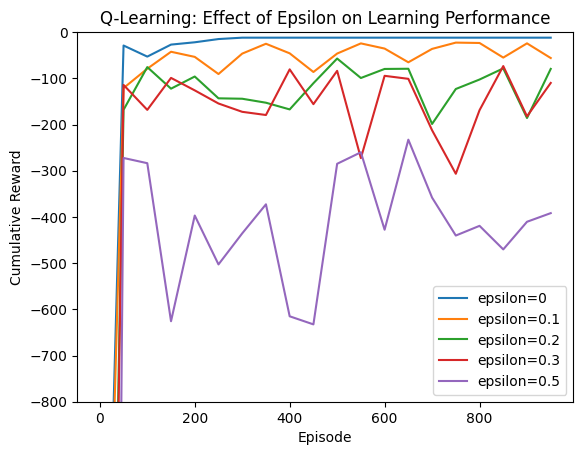

In [7]:
# Test Q-Learning with different epsilon values
print("=" * 60)
print("Q-LEARNING ALGORITHM")
print("=" * 60)

candidate_epsilon = [0, 0.1, 0.2, 0.3, 0.5]

for epsilon in candidate_epsilon:
    print(f"\nTraining Q-Learning with epsilon = {epsilon}")
    Q, rewards = Qlearning(episode_num=1000, epsilon=epsilon)
    
    # Average over 10 runs for stable results
    average_rewards = []
    for i in range(10):
        _, rewards = Qlearning(episode_num=1000, epsilon=epsilon)
        if len(average_rewards) == 0:
            average_rewards = np.array(rewards)
        else:
            average_rewards = average_rewards + np.array(rewards)
    
    average_rewards = average_rewards * 1.0 / 10
    plot(range(1000), average_rewards, labels=f'epsilon={epsilon}')
    print("Final Policy:")
    print_policy(Q)

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.ylim(-800, 0)
plt.title('Q-Learning: Effect of Epsilon on Learning Performance')
plt.legend()
plt.show()



SARSA ALGORITHM

Training SARSA with epsilon = 0
Final Policy:
↓ → ↓ → ↑ ↑ → ← → ↓ → ↓ 
→ → → → → → → ↓ → → ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 


Training SARSA with epsilon = 0.1
Final Policy:
→ → → → → → → → → → → ↓ 
→ → → → → → → → → → → ↓ 
↑ ← ↑ ↑ ↑ ↑ ↑ ↑ ↑ → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 


Training SARSA with epsilon = 0.2
Final Policy:
→ → → → → → → → → → ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ → ↑ ↑ → ↑ ↑ → ↑ ↑ → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 


Training SARSA with epsilon = 0.3
Final Policy:
→ → → → → → → → → → → ↓ 
↑ → → → → → → → → ↑ → ↓ 
↑ ↑ ↑ ↑ ↑ → ↑ ↑ ↑ ↑ → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 


Training SARSA with epsilon = 0.5
Final Policy:
→ → → → → → → → → → → ↓ 
↑ ↑ → ↑ ↑ ↑ → → ↑ → → → 
↑ ↑ ↑ ↑ ↑ ↑ → ↑ ↑ ↑ → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



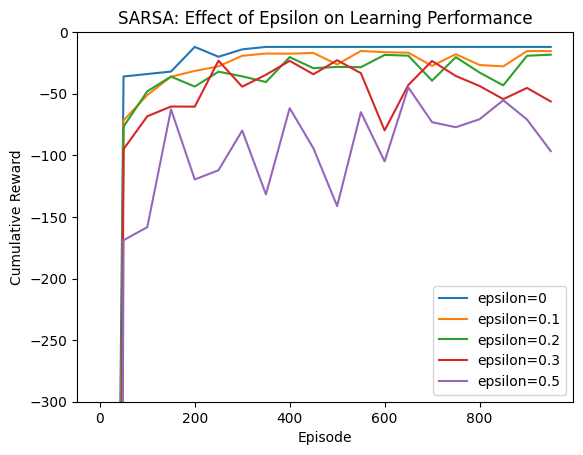

In [8]:
# Test SARSA with different epsilon values
print("\n" + "=" * 60)
print("SARSA ALGORITHM")
print("=" * 60)

for epsilon in candidate_epsilon:
    print(f"\nTraining SARSA with epsilon = {epsilon}")
    env = CliffEnvironment()
    Q, rewards = sarsa(env, episode_nums=1000, epsilon=epsilon)
    
    # Average over 10 runs for stable results
    average_rewards = []
    for i in range(10):
        Q, rewards = sarsa(env, episode_nums=1000, epsilon=epsilon)
        if len(average_rewards) == 0:
            average_rewards = np.array(rewards)
        else:
            average_rewards = average_rewards + np.array(rewards)
    
    average_rewards = average_rewards * 1.0 / 10
    plot(range(1000), average_rewards, labels=f'epsilon={epsilon}')
    print("Final Policy:")
    print_policy(Q)

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.ylim(-300, 0)
plt.title('SARSA: Effect of Epsilon on Learning Performance')
plt.legend()
plt.show()